# NGC UHS4 FOU GWAS
__Author:__ Jesse Marks

This document logs the steps taken to perform a GWAS on the UHS4 data using the frequency of opioid use (FOU) phenotype. 

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* R packages: MASS, moments
* [RVtests](https://render.githubusercontent.com/view/ipynb?commit=3bb8e661ad8b75af027ed2748133452ec251aaed&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f525449496e7465726e6174696f6e616c2f6271756163685f6e6f7465626f6f6b732f336262386536363161643862373561663032376564323734383133333435326563323531616165642f6865726f696e5f70726f6a6563742f646576656c6f702f32303138303131305f756873325f756873335f666f755f677761732e6970796e623f746f6b656e3d41664d79344e373237626e764465456f46535a697770346b48776246577964706b7335617570495a7741253344253344&nwo=RTIInternational%2Fbquach_notebooks&path=heroin_project%2Fdevelop%2F20180110_uhs2_uhs3_fou_gwas.ipynb&repository_id=105297875&repository_type=Repository)

## Data description
### genotype data

Downloaded from `s3://rti-heroin/ngc_vidus_fou/data/genotype`
```

```

### phenotype data
Downloaded from `s3://rti-midas-data/studies/vidus/phenotypes/unprocessed/GWAS-Cohort-n938_passed_g_qc_only_opioid_FOU.csv`
There are 300 subjects in this FOU file. For more information on about these data see `//RTPNFIL02/eojohnson/VIDUS dx/Phenotype data/documentation/Phenotype QC_recoding documentation.pdf`

* female (sex): 0=male & 1=female
* ageatint: Age at time of interview
* useropioid6mfq: Combined heroin and prescription use variable to generate opioid use in past 6 months.

We will perform a Box-Cox transformation on the FOU phenotype variable so that ultimately our phenotype variable will be:
$$zscore(boxcox(\text{useropioid6mfq}+1))$$

### Variable information
The data have already been filtered to
* Remove subjects with Useropioid6mfq == 0
* Remove duplicate subjects by keeping only the more recent data record
* Remove subjects with previously reported sex discrepancy

# Download Data and Create Directory Structure

In [ ]:
## create directory structure ##
study="vidus"
anlist="ea" 
genD=/shared/jmarks/heroin/$study/genotype/observed/ # location of QC'ed genotype data
gwasD=/shared/jmarks/heroin/$study/gwas/fou # base processing dir
phenD=/shared/jmarks/heroin/$study/phenotype # base phenotype dir
eig=$phenD/processing/eig # location of PCA processing dir
mkdir -p $genD $gwasD $phenD/{final,processing,unprocessed} $eig/results 

## Dowload imputed genotype data ##
cd /shared/jmarks/heroin/vidus/genotype/imputed
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name download_imputed_data \
    --script_prefix s3.download \
    --mem 3.5 \
    --nslots 1 \
    --priority 0 \
    --program aws s3 sync s3://rti-heroin/ngc_vidus_fou/data/genotype/imputed/ea .

## Dowload observed genotype data ##
cd /shared/jmarks/heroin/vidus/genotype/observed
aws s3 cp s3://rti-heroin/ngc_vidus_fou/data/genotype/observed/ea/ea_chr_all.bed.gz .
aws s3 cp s3://rti-heroin/ngc_vidus_fou/data/genotype/observed/ea/ea_chr_all.bim.gz .
aws s3 cp s3://rti-heroin/ngc_vidus_fou/data/genotype/observed/ea/ea_chr_all.fam.gz .

## Download semi-processed phenotype data ##
cd /shared/jmarks/heroin/vidus/phenotype/unprocessed
aws s3 cp s3://rti-midas-data/studies/vidus/phenotypes/unprocessed/GWAS-Cohort-n938_passed_g_qc_only_opioid_FOU.csv .

# Prepare Files for Analysis
We follow the process outlined in the NGC protocol for preperations of the phenotype file, even if we don't ultimately use RVTESTS for the analysis. This is so that the phenotype processing steps are consistent.

## Phenotype processing
Create phenotype files for the GWAS. We follow the instructions of the NGC protocol distributed by Eric Johnson. This protocol mandates that we create a phenotype file and a covariate file in PED format, which is what rvtests requires. See the NGC protocol for more information on this format. There are several initial filters and processing steps to be applied to the subject data.

* extract ids of subjects passing genotype QC
* Map sex coding per the NGC protocol, to 1=female & 2=male. 

### Data Wrangling

In [ ]:
cd $phenD
## Extract Variables of interest ##
R
df <- read.csv("unprocessed/GWAS-Cohort-n938_passed_g_qc_only_opioid_FOU.csv")
vars <- c("gwas_code", "female", "ageatint", "useropioid6mfq")
newdf <- df[,vars]
newdf$gwas_code <- sprintf("%04d", newdf$gwas_code)
write.table(newdf, "processing/vidus.phenotype.table", quote=F, sep=" ", row.names = F)

## map sex code ##
for an in $anlist; do
    awk 'NR>1{if ( $2==0) { $2=2} else { $2=1 }} {print $0}' \
        $phenD/processing/vidus.phenotype.table > \
        $phenD/processing/$study.$an.phenotype_table.sex_mapped
done

## filter phenotype data to subjects that passed genotype QC ##
for an in $anlist; do
    cut -d ' ' -f2 $genD/*fam |
    perl -lne '/(_93-)(\d+)/; print $2."\t".$_'  >\
        $phenD/processing/$study.$an.genotype.IDs.4digit
done

# also map the 4 digit number in the phenotype file to the whole genotype ID
for an in $anlist; do
    awk ' FNR==NR{ map[$1]=$2; next} FNR>=2{$1=map[$1]} {print $0};' \
        $phenD/processing/$study.$an.genotype.IDs.4digit \
        $phenD/processing/$study.$an.phenotype_table.sex_mapped > \
        $phenD/processing/$study.$an.phenotype_table.sex_mapped.passed_qc
done

### Phenotype visualization
#### Box-Cox Transformation
Remove individuals with a 0 for FOU and then shift the Box-Cox transformation to a left-anchored distribution at 1.0 (i.e. 1.0 being the lowest value: e.g., once per day or one day per month). Also, add constant 1 to all responses to deal with the fractional responses that are less than 1? 

| Ancestry | Samples Removed (FOU==0) | Total Samples |
|----------|--------------------------|---------------|
| EA       |                          | 300           |

[1] 2.935623

[1] 4.746667

EA count:  300 

EA count after removing samples with FOU==0:  300 



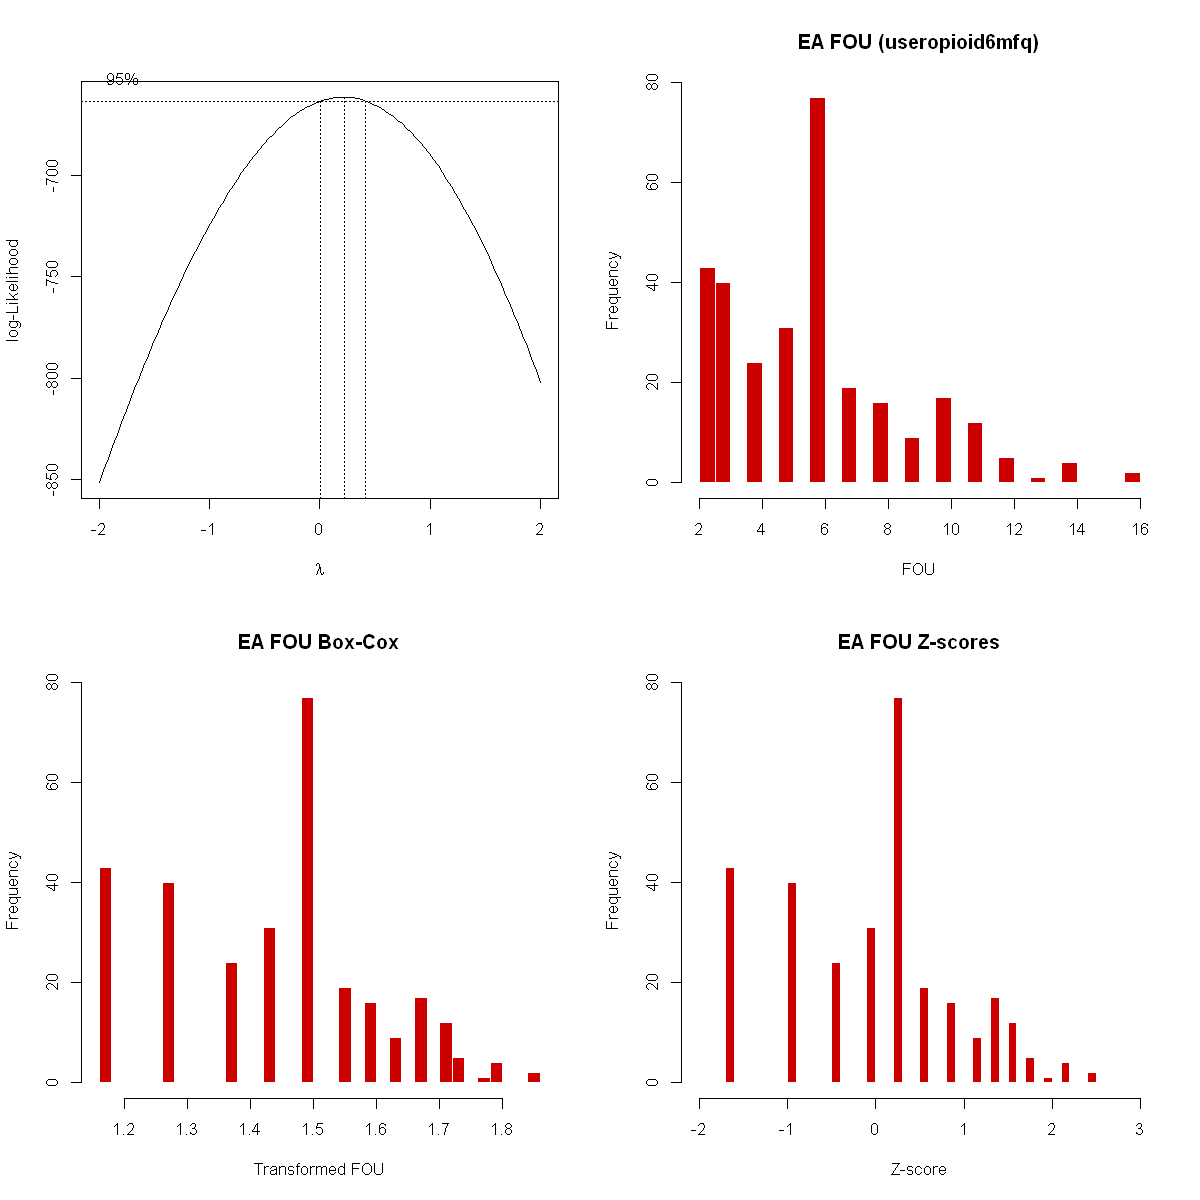

In [7]:
### R console ###
library(MASS)

options(repr.plot.width=10, repr.plot.height=10)
# note that I copied over the phenotype data to my local machine to produce the plots
setwd('C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/fou/phenotype/processing/')
phenotype <- "useropioid6mfq"

ea.fou.data <- read.table("vidus.ea.phenotype_table.sex_mapped.passed_qc", header = T)
sd(ea.fou.data$useropioid6mfq)
mean(ea.fou.data$useropioid6mfq)
#aa.fou.data <- read.table("uhs4.aa.phenotype_table.sex_mapped.passed_qc", header = T)

cat("EA count: ", length(get(phenotype, ea.fou.data)), "\n\n")
#cat("AA count: ", length(aa.fou.data$useropioid6mfq), "\n\n\n\n")


## Remove individuals with 0 for FOU
ea.fou.data <- ea.fou.data[which(get(phenotype, ea.fou.data)!=0),]
#aa.fou.data <- aa.fou.data[which(aa.fou.data$useropioid6mfq!=0),]
cat("EA count after removing samples with FOU==0: ", length(get(phenotype, ea.fou.data)), "\n\n")
#cat("AA count after removing samples with FOU==0: ", length(aa.fou.data$useropioid6mfq), "\n\n")
#
par(mfrow=c(2,2))
## Perform boxcox transform ##
ea.boxcox <- boxcox(useropioid6mfq+1 ~ ageatint + female, data=ea.fou.data)
#aa.boxcox <- boxcox(useropioid6mfq+1 ~ age + sex_selfreport, data=aa.fou.data)
ea.lambda <- ea.boxcox$x[which(ea.boxcox$y==max(ea.boxcox$y))]
#aa.lambda <- aa.boxcox$x[which(aa.boxcox$y==max(aa.boxcox$y))]
#
## Convert to Z-scores ##
ea.zscore <- scale((ea.fou.data$useropioid6mfq+1)^ea.lambda, center=T, scale=T)
#aa.zscore <- scale((aa.fou.data$useropioid6mfq+1)^aa.lambda, center=T, scale=T)
#
hist(ea.fou.data$useropioid6mfq+1, breaks=30, col="red3", 
     border="white", main="EA FOU (useropioid6mfq)", xlab="FOU")
#hist(aa.fou.data$useropioid6mfq+1, breaks=30, col="red3", 
#     border="white", main="AA FOU (useropioid6mfq)", xlab="FOU")
hist((ea.fou.data$useropioid6mfq+1)^ea.lambda, breaks=30, col="red3",
     border="white", main="EA FOU Box-Cox", xlab="Transformed FOU")
#hist((aa.fou.data$useropioid6mfq+1)^aa.lambda, breaks=30, col="red3",
#     border="white", main="AA FOU Box-Cox", xlab="Transformed FOU")
hist(ea.zscore, breaks=30, col="red3", border="white", main="EA FOU Z-scores", xlab="Z-score", xlim=c(-2,3))
#hist(aa.zscore, breaks=30, col="red3", border="white", main="AA FOU Z-scores", xlab="Z-score", xlim=c(-2,3))
#
ea.fou.data$useropioid6mfq <- ea.zscore
#aa.fou.data$useropioid6mfq <- aa.zscore
#
write.table(ea.fou.data,"vidus.ea.phenotype_table.sex_mapped.passed_qc.box_cox" , sep = "\t", row.names = F, quote=F)
#write.table(aa.fou.data,"uhs4.aa.phenotype_table.sex_mapped.passed_qc.box_cox" , sep = "\t", row.names = F, quote=F)

#### Age + Sex 

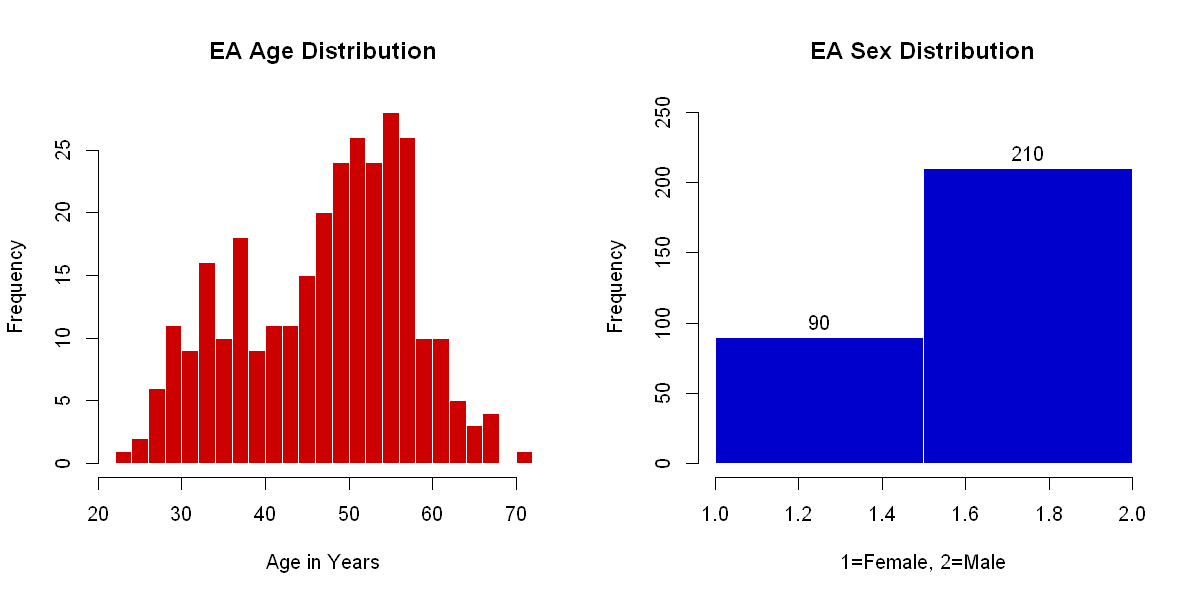

In [33]:
options(repr.plot.width=10, repr.plot.height=5)

#cat("========EA Age Table========")
#table(ea.fou.data$age)
#cat("\n\n========AA Age Table========")
#table(aa.fou.data$age)

#cat("========EA Sex Table========")
#table(ea.fou.data$female)
#cat("\n\n========AA Sex Table========")
#table(aa.fou.data$sex)

par(mfrow=c(1,2))

# Plot age
hist(ea.fou.data$ageatint, breaks=30, col="red3", border="white",
     main="EA Age Distribution", xlab="Age in Years")
#hist(aa.fou.data$age, breaks=30, col="red3", border="white",
#     main="AA Age Distribution", xlab="Age in Years")

# Plot sex
hist(ea.fou.data$female, breaks=2, col="blue3", border="white", 
     main="EA Sex Distribution", xlab="1=Female, 2=Male", labels=T, ylim= c(0,250))
#hist(aa.fou.data$sex, breaks=2, col="blue3", border="white", 
#     main="AA Sex Distribution", xlab="1=Female, 2=Male", labels=T, ylim= c(0,700))


In [ ]:
## upload to EC2
cd ~/Desktop/Projects/heroin/ngc/vidus/fou/phenotype/processing
scp -i ~/.ssh/gwas_rsa *box_cox ec2-user@34.206.166.72:/shared/jmarks/heroin/vidus/phenotype/processing/

## Control for Population Stratification (EIGENSTRAT)
In a GWAS model, one should control for population stratification (or ancestry structure). Population stratification in GWA studies can lead to spurious correlations or reduced power. One can control for stratification by including in the GWAS statisical model the top genotype principal components (PCs) as covariates. These genotype PCs capture the phenotypic variance explained by population stratification.

Here we use the software tool EIGENSTRAT that performs a PCA on the genotype data. EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group.

### Construct subject-filtered PLINK file sets
Generate a new set of genotype data filtered by the phenotype information. Perform LD-pruning on these observed genotype data for the PCA. 

In [ ]:
## generate new set of genotype data ##
for an in $anlist; do
    awk 'NR>=2{print $1,$1}' $phenD/processing/$study.$an.phenotype_table.sex_mapped.passed_qc.box_cox > \
        $phenD/processing/$study.$an.final_ids

    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $genD/ea_chr_all \
        --keep $phenD/processing/$study.$an.final_ids \
        --make-bed \
        --out $eig/$study.$an.genotypes
done

### Remove high-LD region variants

In [ ]:
# Remove high-LD region variants
for an in $anlist; do
    # Generate list of variants in known high-LD regions
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/$study.$an.genotypes.bim  > $eig/$study.$an.high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/$study.$an.genotypes \
        --exclude $eig/$study.$an.high_ld_regions.remove \
        --make-bed \
        --out $eig/${an}_high_ld_regions_removed
done &

### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using PLINK `--indep-pairwise.`

In [ ]:
# Remove high-LD region variants
for an in $anlist; do
    # Run per chromosome LD pruning for each chr
    for chr in {1..22}; do
         /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${an}_${chr}_ld_prune \
            --script_prefix $eig/${an}_${chr}_ld_prune \
            --mem 3.5 \
            --nslots 1 \
            --priority 0 \
            --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
                --noweb \
                --memory 3500 \
                --bfile $eig/${an}_high_ld_regions_removed \
                --indep-pairwise 1500 150 0.2 \
                --chr ${chr} \
                --out $eig/${an}_chr${chr}_ld_pruned
    done
done

#Create LD pruned PLINK file sets
for ancestry in $anlist; do
    # Merge *prune.in files
    cat $eig/${ancestry}_chr*_ld_pruned.prune.in > $eig/${ancestry}_chr_all_ld_pruned.prune.in
    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 2048 \
        --bfile $eig/${ancestry}_high_ld_regions_removed \
        --extract $eig/${ancestry}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/${ancestry}_ld_pruned
done


# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*qsub*
rm $eig/*nosex

wc -l $eig/*bim
wc -l $eig/*fam

### Rename BIM/FAM file IDs
Variant IDs in the PLINK bim file have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. The family IDs in the PLINK fam files similarly throw an error in smartpca should the number of characters in the IDs be more than 39. For this reason, we will apply an analogous renaming convention.

In [ ]:
# Count ID lengths greater than 39 characters
for ancestry in $anlist; do
    echo -e "\n\n======== ${ancestry} ========\n\n"
    awk '{ if(length($1)+length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned.fam | wc -l
    awk '{ if(length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned.bim | wc -l
done

for ancestry in $anlist; do
    # Rename FAM file IDs
    # Make new FAM
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/${ancestry}_ld_pruned.fam \
        > $eig/${ancestry}_ld_pruned_id_renamed.fam
    awk '{ if(length($1)+length($2)>39){print $2} }' $eig/${ancestry}_ld_pruned_id_renamed.fam | wc -l

#    # Rename BIM file IDs
#    # Make new BIM
#    awk '{$2="ID_"NR; print $0}' $eig/${ancestry}_ld_pruned.bim \
#        > $eig/${ancestry}_ld_pruned_id_renamed.bim
done

### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT bin directory should be in ~/.bashrc as an addition to the PATH variable. If it is not, it can be added as following

`export PATH=$PATH:/shared/bioinformatics/software/third_party/EIG-6.1.4/bin/` # Add EIGENSOFT bin to path

The `smartpca.pl` program documentation is shown below:


DOCUMENTATION of `smartpca.pl` program:

This program calls the `smartpca` program (see ../POPGEN/README). 
For this to work, the bin directory containing `smartpca` MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
# Run smartpca
for ancestry in $anlist; do
    famfile="$eig/${ancestry}_ld_pruned_id_renamed.fam"
    bimfile="$eig/${ancestry}_ld_pruned.bim"
    bedfile="$eig/${ancestry}_ld_pruned.bed"

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.smartpca.$ancestry \
        --script_prefix $eig/results/smartpca.$study.${ancestry} \
        --mem 7.5 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
            -i $bedfile \
            -a $bimfile \
            -b $famfile \
            -o $eig/results/${ancestry}_ld_pruned.pca \
            -p $eig/results/${ancestry}_ld_pruned.plot \
            -e $eig/results/${ancestry}_ld_pruned.eval \
            -l $eig/results/${ancestry}_ld_pruned.pca.log \
            -m 0
done

#### Extract Eigenvectors

In [ ]:
# Grab top 10 eigenvectors from PCA 
for ancestry in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${ancestry}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${ancestry}_ld_pruned_top10_eigenvecs.txt
done

#### View PCs from EIGENSTRAT
Copy results over to local machine.

In [ ]:
## local machine ##
cd /home/jmarks/Desktop/Projects/heroin/ngc/vidus/fou/phenotype/processing/eig
scp -i ~/.ssh/gwas_rsa ec2-user@34.206.166.72:/shared/jmarks/heroin/vidus/phenotype/processing/eig/results/* .

In [9]:
# Load PCA data
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/fou/phenotype/processing/eig/")
options(stringsAsFactors=F)
ea.evec <- read.table("ea_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
ea.evec[1:5,]
#aa.evec <- read.table("aa_ld_pruned.pca.evec",
#                      comment.char="#", sep="", row.names=1)
#aa.evec[1:5,]

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
ID_1:ID_1,-0.0150,-0.0209,0.0317,0.0181,-0.0271,0.0076,-0.0972,-0.0002,-0.0083,-0.0060,???
ID_2:ID_2,0.0152,-0.0015,0.0136,0.0400,0.0199,-0.0013,-0.0385,-0.0011,0.0500,0.0008,???
ID_3:ID_3,0.2426,0.8167,0.4372,0.0930,-0.0186,-0.1023,0.0041,0.0253,-0.1020,0.0318,???
ID_4:ID_4,-0.0178,0.0207,-0.0026,0.0043,-0.0293,-0.0267,0.0282,0.0178,-0.0051,-0.0165,???
ID_5:ID_5,-0.0308,0.0048,-0.0052,-0.0177,0.0097,-0.0280,0.0488,-0.0166,0.0274,0.0106,???


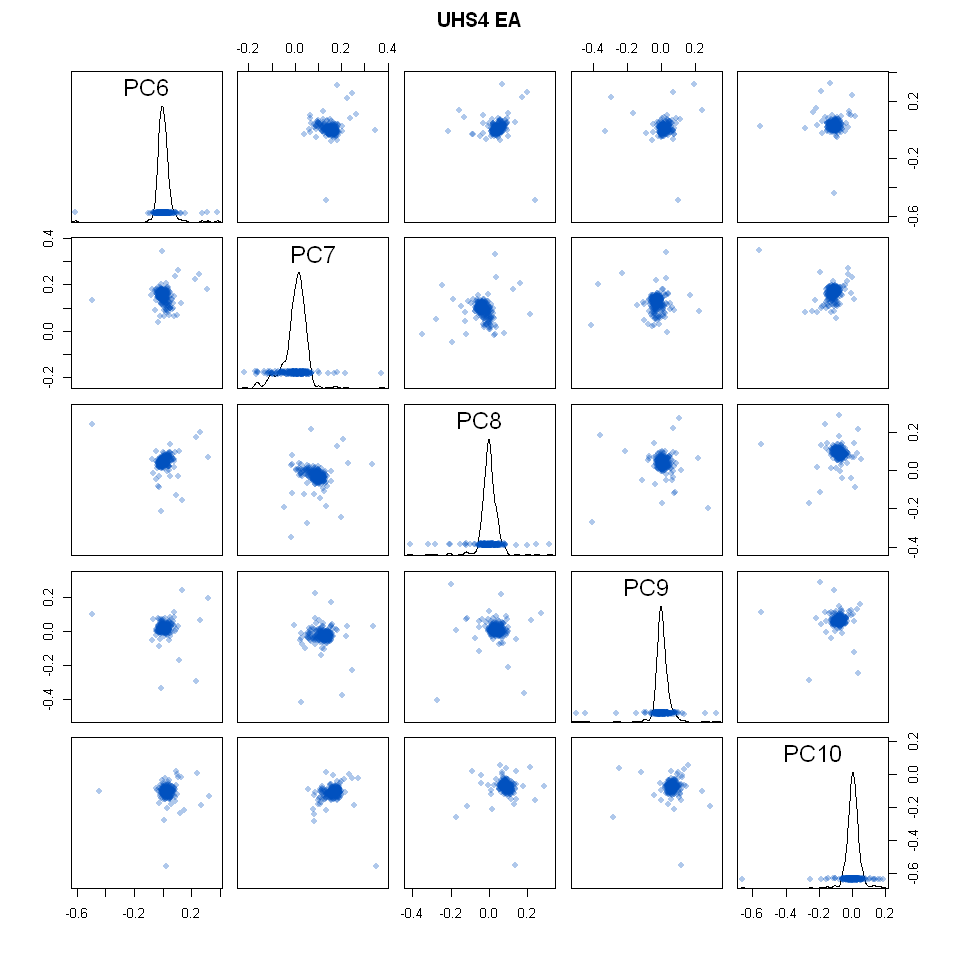

ERROR: Error in eval(expr, envir, enclos): object 'aa.evec' not found


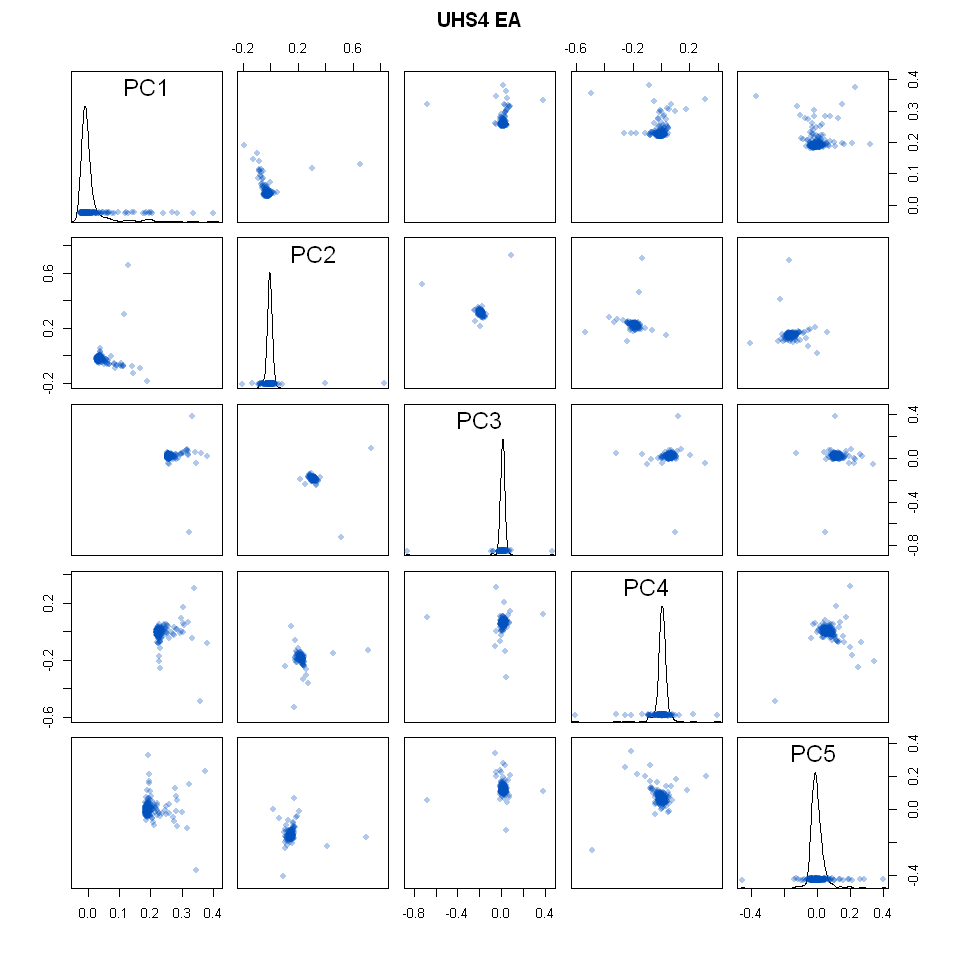

In [10]:
### R console ###

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

## EA ##
#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 EA", cex.main=1)

## AA ##
#Run PCA and get % variance
aa.dspace <- aa.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=aa.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="UHS4 AA", cex.main=1)

### PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance. Make PED format phenotype and covariate file according to the NGC protocol.


#### Create ped file
The GWAS software tool accepts a phenotype file and a covariate file. We will create those files here and refer to them as ped and cov files.

In [11]:
create_pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry){
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[1]
    # covariate file
    num_cols <- 14 + length(covs)
    covar_data <- data.frame(matrix(ncol=num_cols, nrow=ped_length))
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covs,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covs){
        covar_data[,i] <- pheno_data[,i]
    }
    
    covar_data[, (num_cols-9):num_cols] <- pca_data[,3:12]
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
    head(ped_file)
    #head(covar_data)
    
    } # end function

#### Regression analysis
We use a regression model of the general structure:

$$\begin{align}
\text{Phenotype = PC1 + PC2 + ... + PC10}
\end{align}$$

In [12]:
regression_analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry){
    options(stringsAsFactors=F)
    
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}

##### EA

fid,iid,patid,matid,female,useropioid6mfq
8005964642_NA0053910_93-0002,8005964642_NA0053910_93-0002,NA,NA,2,-1.61892208
8005964654_NA0053915_93-0003,8005964654_NA0053915_93-0003,NA,NA,2,-0.06626018
8005964583_NA0053919_93-0005,8005964583_NA0053919_93-0005,NA,NA,2,1.33723732
8005964584_NA0053917_93-0006,8005964584_NA0053917_93-0006,NA,NA,1,0.28221736
8005964607_NA0053927_93-0011,8005964607_NA0053927_93-0011,NA,NA,1,0.28221736
8005964595_NA0053929_93-0013,8005964595_NA0053929_93-0013,NA,NA,2,0.86161113


MODEL FORMULA:

 useropioid6mfq~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EUR group ================
Top PCs:  PC5 PC2 PC10 
PVE:      80.33

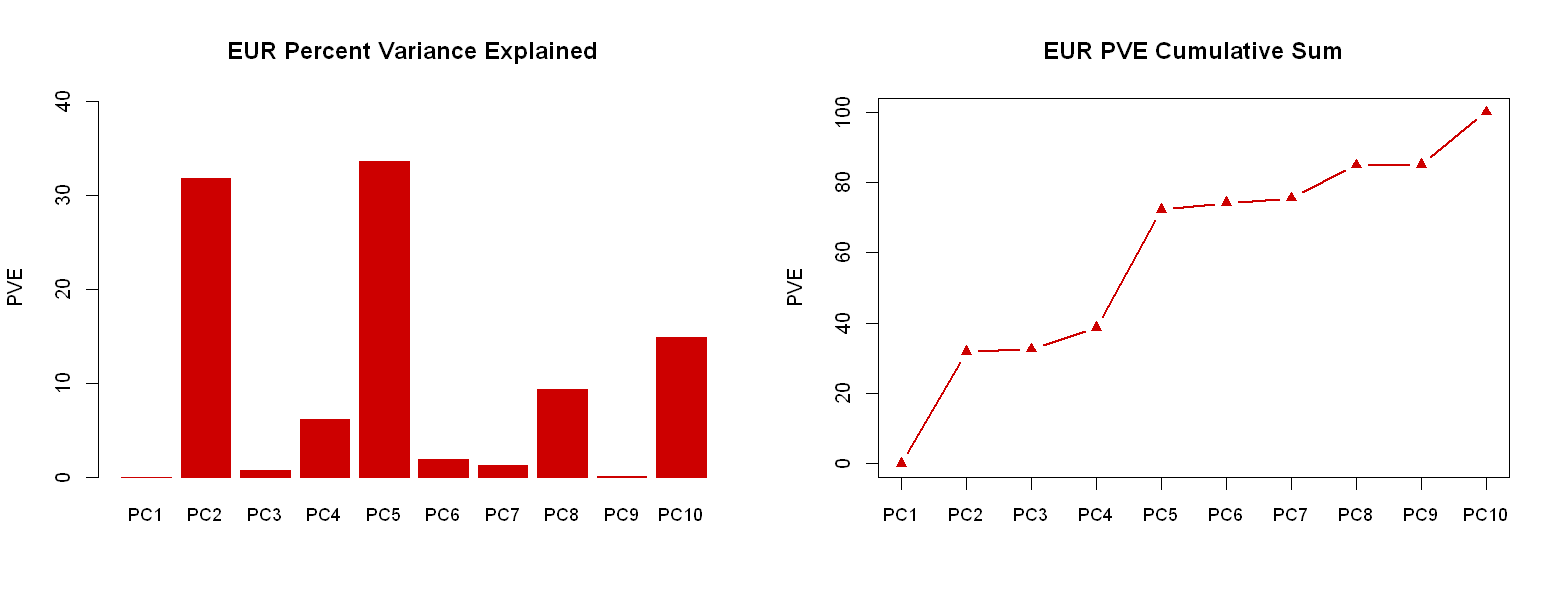

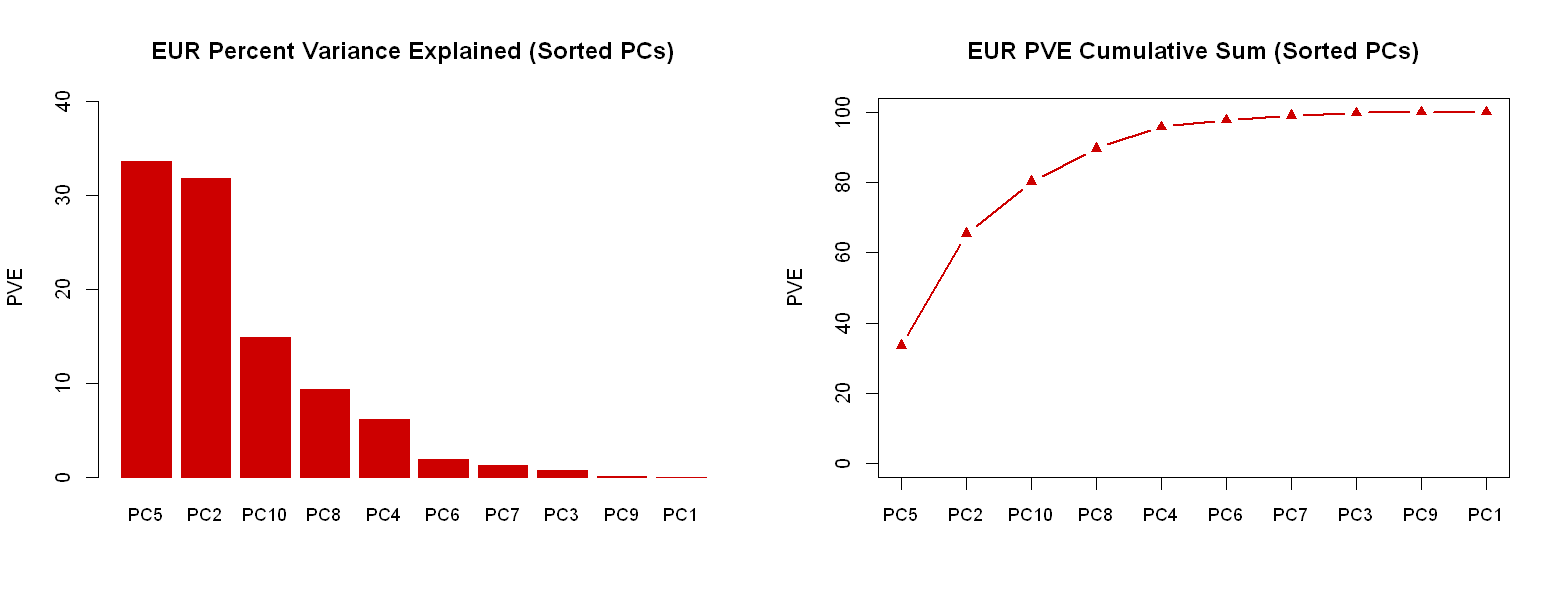

In [24]:
#setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus//fou/phenotype/processing/")
study <- "VIDUS"
ancestry <- "EUR" # EUR or AFR
phenotype <- "useropioid6mfq"
sex_var <-  "female"
covs <- c("ageatint", "female")
phen_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/fou/phenotype/processing/vidus.ea.phenotype_table.sex_mapped.passed_qc.box_cox"
pca_file <- "C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/heroin/ngc/vidus/fou/phenotype/processing/eig/ea_ld_pruned_top10_eigenvecs.txt"
model_type <- "continuous" # continuous or logistic
cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create_pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=cov_file, study=study, ancestry=ancestry)
regression_analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry)

### Alter IID
The imputation files have a unique ID that we must match with our IID. Specifically, the ID
in the imputation files is of the for: <br>
`iid_iid` <br>
so we match our phen and cov ped files to match this.

In [ ]:
## Bash ##
cd /home/jmarks/Desktop/Projects/heroin/ngc/vidus/fou/phenotype/processing

## AA
#awk '{OFS="_"} { print $2,$2 } ' VIDUS_AFR_phen.ped > new_id
#awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
#    new_id VIDUS_AFR_phen.ped > VIDUS_NGCW1_AFR_phen.ped
#awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
#    new_id VIDUS_AFR_cov.ped > VIDUS_NGCW1_AFR_cov.ped


# EA
awk '{OFS="_"} { print $2,$2 } ' VIDUS_EUR_phen.ped > new_id
awk 'NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id VIDUS_EUR_phen.ped > VIDUS_NGCW1_EUR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id VIDUS_EUR_cov.ped > VIDUS_NGCW1_EUR_cov.ped

scp -i ~/.ssh/gwas_rsa *NGCW1* ec2-user@34.206.166.72:/shared/jmarks/heroin/vidus/phenotype/final/

# Genotype Data
Prepare genotype data for analysis software.
## Inflate imputation results
The imputed genotype data from the Michigan Imputation Server have already been inflated.

## Run GWAS
### Autosomes

In [ ]:
# Command line # 
study="VIDUS" # should match study_name in phenotype file
version=001
ngc="fou"
phenotype="useropioid6mfq"
for ancestry in $anlist; do

    if [[ $ancestry == "aa" ]]; then
        covars="age,sex_selfreport,PC9,PC5,PC2,PC8"
        pop=AFR
    elif [[ $ancestry == "ha" ]]; then
        pop=AMR
    else
        covars="age,sex_selfreport,PC5,PC2,PC10"
        pop=EUR
    fi

    genD=/shared/jmarks/heroin/vidus/genotype/imputed
    procD=/shared/jmarks/heroin/vidus/gwas/fou/$ancestry/$version
    phenD=/shared/jmarks/heroin/vidus/phenotype/final

    mkdir -p $procD/final
    for chr in {1..22};do
        mkdir -p $procD/processing/chr$chr
    done

#####################################################################################
    # Run RVtest for autosomes
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name $study.${ancestry}_${chr}_rvtest \
            --script_prefix $procD/processing/chr$chr/${ancestry}_${chr}_rvtest \
            --mem 7.5 \
            --nslots 2 \
            --priority 0 \
                --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
                --inVcf $genD/chr${chr}.dose.vcf.gz \
                --pheno $phenD/${study}_NGCW1_${pop}_phen.ped \
                --pheno-name $phenotype \
                --covar $phenD/${study}_NGCW1_${pop}_cov.ped \
                --covar-name $covars \
                --meta score \
                --dosage DS \
                --out $procD/processing/chr$chr/$study.$pop.1000G.$ngc.chr$chr
    done
done

### ChrX  TODO

## Results processing

### Unfiltered results

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/data/assoc_tests

# Concatenate chr results together
ancestry="EUR"
echo -e "\n\n ======== ${ancestry} ======== \n\n"
for chr in {1..22}; do
    zgrep -P "^${chr}\s" VIDUS_${ancestry}_1000G_fou_chr${chr}.MetaScore.assoc.gz
done |
    gzip -c > VIDUS_${ancestry}_1000G_fou.gz

# Make results table
ancestry="EUR"
outfile=VIDUS_${ancestry}_1000G_fou.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=VIDUS_${ancestry}_1000G_fou.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile

# Make Q-Q and manhattan plots
ancestry=EUR
# Plot all chromosomes
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix VIDUS_${ancestry}_1000G_fou.assoc.plot \
    --mem 30.6 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in VIDUS_${ancestry}_1000G_fou.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out VIDUS_${ancestry}_1000G_fou.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

### MAF > 0.01 and imputation quality > 0.3

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/data/assoc_tests

# Get list of variants to filter by imputation quality
ancestry="ea"
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    zcat ../../genotype/imputed/vidus_imputed/chr${chr}.info.gz | \
        tail -n +2 | \
        awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
        > ${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
done

# Filter results files
ancestry=EUR
for chr in {1..22}; do
    echo "chr${chr}..."
    awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
        ea_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
        <(zgrep -P "^${chr}\s" VIDUS_${ancestry}_1000G_fou_chr${chr}.MetaScore.assoc.gz) \
        > VIDUS_${ancestry}_1000G_fou_chr${chr}.tmp
done 
cat VIDUS_${ancestry}_1000G_fou_chr*tmp | gzip -c > VIDUS_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.gz

# Clean up
rm *tmp

# Make results table
ancestry="EUR"
outfile=VIDUS_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=VIDUS_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile

# Make Q-Q and manhattan plots
ancestry="EUR"
# Plot all chromosomes
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix VIDUS_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.plot \
    --mem 30.6 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in VIDUS_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out VIDUS_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

## PCA Plots
The NGC protocol calls for the submission of the samples projected onto 1000G superpopulation PCA space (EUR, AFR, EAS).

In [ ]:
mkdir -p /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g/1000g
cd /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g

cp ../eigenstrat/ea_ld_pruned.bim .
awk '{print $2}' ea_ld_pruned.bim > all_pruned_variant_ids

cd 1000g
# Rename 1000G autosome variant IDs
ancestry=ea
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix ${ancestry}_chr${chr}_id_rename \
        --mem 8 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bim \
        --file_out chr${chr}_renamed.bim \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
        --file_in_header 0 \
        --file_in_id_col 1 \
        --file_in_chr_col 0 \
        --file_in_pos_col 3 \
        --file_in_a1_col 4 \
        --file_in_a2_col 5 \
        --chr ${chr}
done

# get list of all variant IDs
touch all_1000g_variants_renamed
for chr in {1..22};do
awk '{ print $2 }' chr${chr}_renamed.bim >> all_1000g_variants_renamed
done

sort all_1000g_variants_renamed > all_1000g_variants_renamed_sorted
sort ../all_study_variants_renamed > all_study_variants_renamed_sorted

# get overlap between 1000g variants and study variants (pruned)
comm ../all_study_variants_renamed_sorted all_1000g_variants_renamed_sorted > ../variant_overlap

# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1,$1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > 1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1,$1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    >> 1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1,$1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    >> 1000g_subject_IDs



# create binary filesets with ld pruned snps
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}_filter \
        --script_prefix ancestry_partition_chr${chr} \
        --mem 8 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
            --noweb \
            --memory 10000 \
            --bim chr${chr}_renamed.bim \
            --fam /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.fam \
            --bed /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bed \
            --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
            --keep 1000g_subject_IDs \
            --extract ../variant_overlap \
            --make-bed \
            --out 1000g_chr${chr}_ld_pruned
done

touch autosome_merge_list.txt
for chr in {1..22};do
   echo "1000g_chr${chr}_ld_pruned" >> autosome_merge_list.txt
done

# merge 1000g autosomes
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name merge_plink_filesets \
    --script_prefix merge_plink_filesets \
    --mem 4 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --merge-list autosome_merge_list.txt \
        --snps-only just-acgt \
        --make-bed \
        --out 1000g_all_auto_ld_pruned

cd /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g

# filter study data to the variants that overlap with 1000g
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ea_ld_pruned \
    --extract variant_overlap \
    --exclude study_and_1000g_combined_ld_pruned-merge.missnp \
    --make-bed \
    --out ea_ld_pruned_1000g_overlap

# Attempt merge 1000g with study data. produced 8 snps that were ambiguous (will remove)
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile 1000g/1000g_all_auto_ld_pruned \
    --bmerge ea_ld_pruned_1000g_overlap \
    --snps-only just-acgt \
    --make-bed \
    --out study_and_1000g_combined_ld_pruned


# Exclude ambiguous snps (polymorphic) from study data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ea_ld_pruned_ld_pruned_1000g_overlap \
    --exclude study_and_1000g_combined_ld_pruned-merge.missnp \
    --make-bed \
    --out ea_ld_pruned_1000g_overlap_removed_ambig


# Exclude ambiguous snps (polymorphic) from 1000g data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile 1000g/1000g_all_auto_ld_pruned \
    --exclude study_and_1000g_combined_ld_pruned-merge.missnp \
    --make-bed \
    --out 1000g/1000g_all_auto_ld_pruned_removed_ambig

# Attempt merge 1000g with study data.
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile 1000g/1000g_all_auto_ld_pruned_removed_ambig \
    --bmerge ea_ld_pruned_1000g_overlap_removed_ambig \
    --snps-only just-acgt \
    --make-bed \
    --out study_and_1000g_combined_ld_pruned_removed_ambig

### Rename BIM/FAM file IDs
BIM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. FAM file IDs are treated similarly.

In [ ]:
# EC2 command line #
cd /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g


# make not a case nor control in fam file
awk '{$6= "-9"} {print $0}' study_and_1000g_combined_ld_pruned_removed_ambig.fam > final.fam

# rename study IIDs
awk 'NR<=300 { $2="ID_"NR; } {print $0}' final.fam > final_renamed.fam

## Eigenstrat on LD pruned snps - study & 1000g merged

In [ ]:
mkdir -p /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g/results
cd /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g

# Run smartpca
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name study_vs_1000g_smartpca \
    --script_prefix smartpca_study_vs_1000g_ \
    --mem 8 \
    --nslots 2 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i study_and_1000g_combined_ld_pruned_removed_ambig.bed \
        -a study_and_1000g_combined_ld_pruned_removed_ambig.bim \
        -b final_renamed.fam \
        -o results/study_and_1000g_ld_snps.pca \
        -p results/study_and_1000g_ld_snps.plot \
        -e results/study_and_1000g_ld_snps.eval \
        -l results/study_and_1000g_ld_snps.pca.log \
        -m 0

### PCA plotting

In [ ]:
cd /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g/results
 
# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > AFR_1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > EAS_1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > EUR_1000g_subject_IDs

In [ ]:
cd /shared/sandbox/ngc_vidus-fou/cohort_projected_on_1000g/results
# Load PCA data
options(stringsAsFactors=F)
study.vs_1000 <- read.table("study_and_1000g_ld_snps.pca.evec", comment.char="#", sep="", row.names=1)

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
dspace <- study.vs_1000[1:10] #transformed dataspace

AFR = scan(file="AFR_1000g_subject_IDs", what=character())
EAS = scan(file="EAS_1000g_subject_IDs", what=character())
EUR = scan(file="EUR_1000g_subject_IDs", what=character())

#Color label samples
sample.names <- row.names(study.vs_1000)
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern="80059|_93-", ignore.case=F)] <- rgb(255,0,0,80, maxColorValue=255) #red
label.colors[grepl(x=sample.names, pattern=paste(EUR,collapse="|"), ignore.case=F)] <- rgb(0,0,255,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern=paste(EAS,collapse="|"), ignore.case=F)] <- rgb(0,255,0,80, maxColorValue=255) #green
label.colors[grepl(x=sample.names, pattern=paste(AFR,collapse="|"), ignore.case=F)] <- rgb(255,215,0,80, maxColorValue=255) #gold
legend.cols <- c(rgb(255,215,0,255, maxColorValue=255), rgb(0,255,0,255, maxColorValue=255),
                 rgb(0,0,255,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=dspace[,1:4], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:4), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="Lung Cancer in Never Smokers vs 1000G", cex.main=1)
legend("bottom", c("AFR", "EAS", "EUR", "LCNS"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)

## S3 data transfer

In [ ]:
# Copy phenotype data
cd /shared/sandbox/ngc_vidus-fou/phenotype
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/data/phenotype --recursive --exclude="*" --include="*ped.gz" --quiet &

cd /shared/sandbox/ngc_vidus-fou/data/assoc_tests
# Copy association test results
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/results/rvtest/ --recursive --exclude="*" --include="*MetaScore*gz*" --quiet &
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/results/figures/ --recursive --exclude="*" --include="*.png.gz" --quiet &


# copy imputation files
cd /shared/sandbox/ngc_vidus-fou/genotype/imputed/vidus_imputed
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/data/genotype/imputed/${ancestry}/ --recursive --exclude "*" --include "*.log"
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/data/genotype/imputed/${ancestry}/ --recursive --exclude "*" --include "*.info.gz" 
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/data/genotype/imputed/${ancestry}/ --recursive  --quiet --exclude "*" --include "*dose.vcf.gz"
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/data/genotype/imputed/${ancestry}/ --recursive --quiet --exclude "*" --include "*dose.vcf.gz.tbi" &


# copy original genotype data
cd /shared/sandbox/ngc_vidus-fou/genotype/original/final
aws s3 cp ./ s3://rti-heroin/ngc_vidus_fou/data/genotype/original/ea/ --recursive --quiet &